In [1]:
from disent.systems.vae import VaeSystem
# from disent.visualize.util import plt_images_grid, plt_images_minimal_square, reconstructions_to_images, notebook_display_animation
# from disent.visualize.visualize_dataset import visualise_get_still_images, visualise_get_animations
# from disent.visualize.visualize_model import latent_traversal_1d_multi_dim
from disent.util import to_numpy, load_model, save_model
from disent.visualize.notebook import *

import numpy as np
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import os

import imageio

# Visualise Datasets

In [2]:
DATASET = ['3dshapes', 'dsprites', 'xygrid'][0]

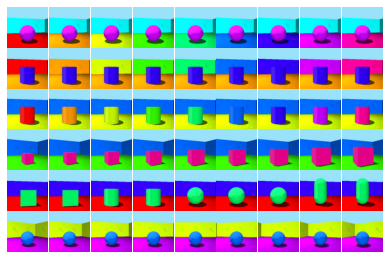

In [3]:
plt_sample_dataset_still_images(DATASET, 9)

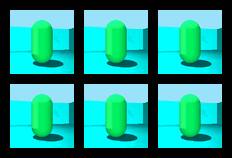

In [4]:
notebook_display_sample_dataset_animation(DATASET, 9)

# Helper Functions

In [5]:
def get_latent_outputs(system, num_samples=1000):
    means, logvars = [], []
    for i, batch in enumerate(DataLoader(system.dataset_train, batch_size=1, shuffle=True)):
        try:
            x, _ = batch
        except:
            x = batch
        z_mean, z_logvar = system.model.encode_gaussian(x.cuda())
        means.append(z_mean.cpu().detach().numpy()[0])
        logvars.append(z_logvar.cpu().detach().numpy()[0])
        if i >= num_samples:
            break
    means, logvars = np.array(means), np.array(logvars)
    return means, logvars #, np.exp(logvars).mean(axis=0)
    
def plot_system_mean_and_var(system, num_samples=100):
    means, logvars = get_latent_outputs(system, num_samples)
    
    means_mean, means_std = means.mean(axis=0), means.std(axis=0)
    logvars = np.exp(logvars) ** 0.5
    logvar_mean, logvar_std = logvars.mean(axis=0), logvars.std(axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    
    ax1.set_title('z_mean')
    ax1.set_xlabel('idx')
    ax1.set_ylabel('value')
    ax1.errorbar(np.arange(len(means_mean)), means_mean, yerr=means_std)

    ax2.set_title('exp(z_logvar) ** 0.5')
    ax2.set_xlabel('idx')
    ax2.set_ylabel('value')
    ax2.errorbar(np.arange(len(logvar_mean)), logvar_mean, yerr=logvar_std)

def train_system(loss='ada-gvae', dataset='dsprites', model='simple-fc', z_size=6, epochs=1, steps=None, save_path=None, load_path=None, train=True):
    system = VaeSystem(dataset_train=dataset, model=model, loss=loss, hparams=dict(lr=0.001, num_workers=8, batch_size=64, z_size=z_size))
    if load_path:
        # system.load_from_checkpoint(checkpoint_path=PATH)
        system = load_model(system, load_path, cuda=False)
    if train:
        trainer = system.quick_train(epochs=epochs, steps=steps)
        if save_path:
            # trainer.save_checkpoint(save_path)
            save_model(system, save_path)
    return system #, trainer

# Initialise Model

In [6]:
# # try: del system
# # except: pass
# # try: del trainer
# # except: pass

# PATH = 'data/trained-e1-3dshapes-simple-fc.ckpt'
# system = train_system(loss='beta-vae', dataset='3dshapes', epochs=1, steps=None, model='simple-fc', save_path=PATH, load_path=None, train=True)
# system = system.cuda()

In [7]:
system2 = train_system(loss='beta-vae', dataset='3dshapes', epochs=1, steps=None, model='simple-fc', save_path=None, load_path='data/trained-e1-3dshapes-simple-fc.ckpt', train=False)
system2 = system2.cuda()

[MODEL]: loaded data/trained-e1-3dshapes-simple-fc.ckpt (cuda: False)


# Plot Random Latent Guassian Samples

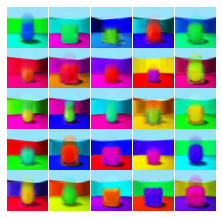

In [8]:
plt_latent_random_samples(system2, 25)

# Visualise Reconstructions

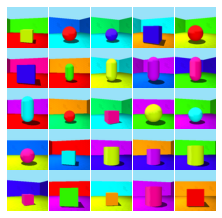

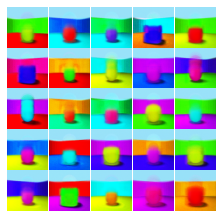

In [9]:
plt_sample_observations_and_reconstruct(system2, num_samples=25);

# Visualise Latent Traversals

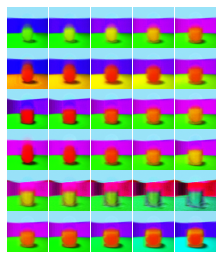

In [10]:
plt_traverse_latent_space(system2, num_samples=1, values=5, dimensions=None)

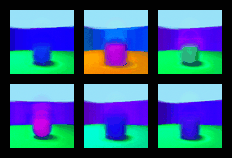

In [11]:
notebook_display_traverse_latent_space(system2, num_samples=1, values=21, dimensions=None, fps=10)

# Visualise Latent Cycles

target


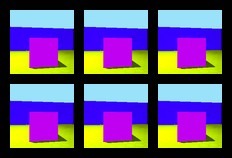

std_gaussian_cycle


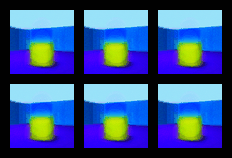

fitted_gaussian_cycle


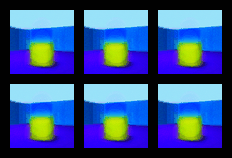

fixed_interval_cycle


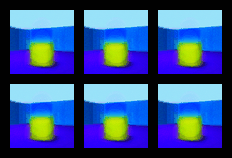

conf_interval_cycle


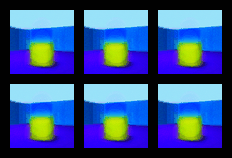

minmax_interval_cycle


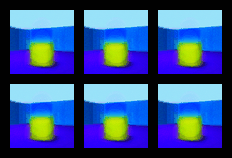

In [12]:
print('target')
notebook_display_sample_dataset_animation(DATASET, 9)

obs = torch.stack(system2.dataset_train.sample_observations(128)).cuda()
for mode in LATENT_CYCLE_MODES:
    print(mode)
    notebook_display_latent_cycle(system2, mode=mode, obs=obs)

## MINI TESTS

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 774   
9  | model.gaussian_encoder.enc3logvar | Linear               | 774   
10 | model.decoder                     | DecoderSimpl

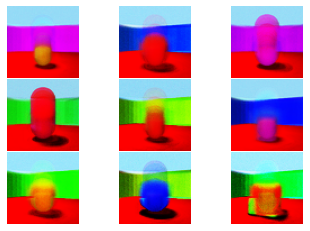

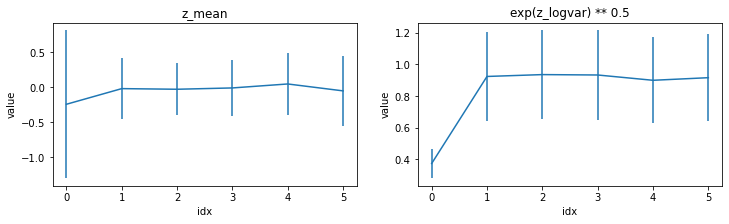

In [128]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=6, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 387   
9  | model.gaussian_encoder.enc3logvar | Linear               | 387   
10 | model.decoder                     | DecoderSimpl

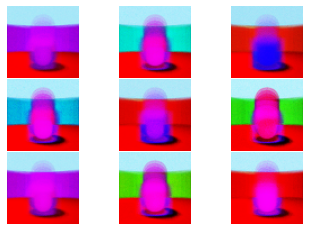

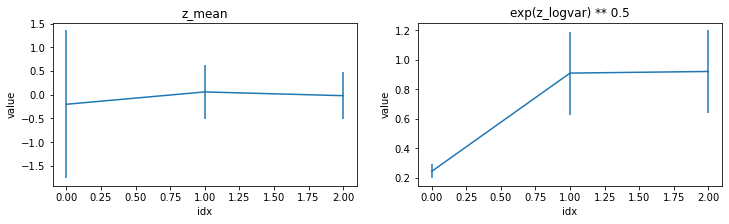

In [129]:


fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=3, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 1 K   
9  | model.gaussian_encoder.enc3logvar | Linear               | 1 K   
10 | model.decoder                     | DecoderSimpl

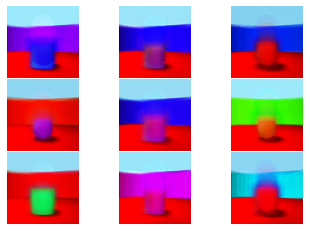

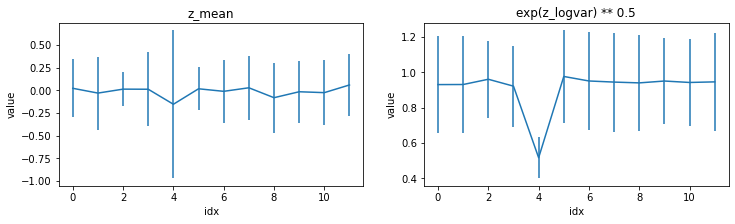

In [130]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=12, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

In [ ]:
z_mean, z_logvar = N()



INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 774   
9  | model.gaussian_encoder.enc3logvar | Linear               | 774   
10 | model.decoder                     | DecoderSimpl

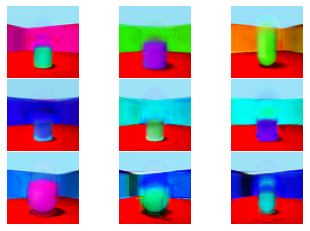

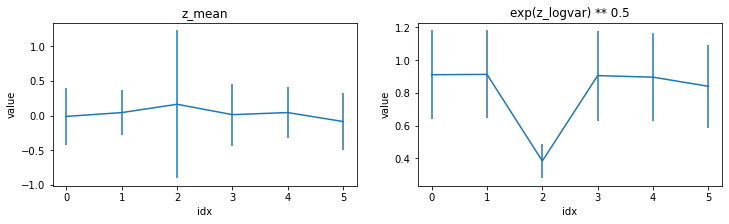

In [138]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=6, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 387   
9  | model.gaussian_encoder.enc3logvar | Linear               | 387   
10 | model.decoder                     | DecoderSimpl

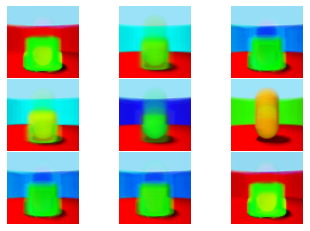

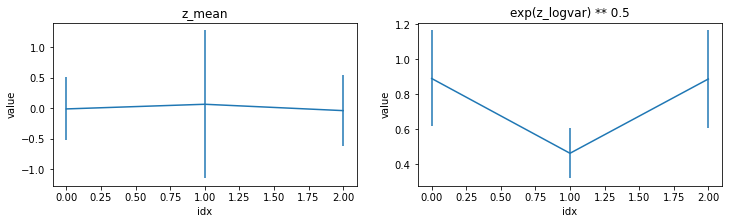

In [136]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=3, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 1 K   
9  | model.gaussian_encoder.enc3logvar | Linear               | 1 K   
10 | model.decoder                     | DecoderSimpl

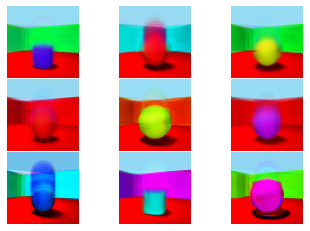

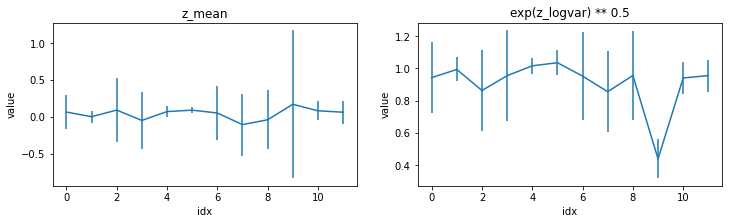

In [137]:
fc_system, fc_trainer = train_system(loss='beta-vae', z_dim=12, epochs=5)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

In [ ]:
[6, 6, 6, 24 , 3, 2]